In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import analysis_helpers as ah
import seaborn as sns
import warnings
from surprise import SVD, SVDpp, Dataset, accuracy, Reader
from surprise.model_selection import train_test_split

warnings.filterwarnings('ignore')
rus_master_loc = '/Users/colinbrochard/DSI_Capstone_local/MtProjRec/2_data/3_rus/rusfiles/rus_master.csv'
np.random.seed(2)

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Mountain Project Recommender Analysis

### Read RUS data into DF and generate samples
Here we read in "Route User Star" data. Each row contains a user route combination and the rating that a user gave to the route on a 4-star scale. We also generat two random samples:
 - `df_sample`: takes a random 100k rows out of the original 1.4M row dataframe
 - `df_better_sample`: samples ~1/3 of the users and routes contained in the original df and then returns the df for just those routes and users. We will see why this is the 'better' sample below. Note that with fewer routes and users than we selected since dropping some user rows will take out some routes and visa versa.

In [2]:
df = pd.read_csv(rus_master_loc)[['user','route','num_stars']]
df_sample = df.sample(100000)
df_better_sample = ah.better_sample(df,12000,32000)

In [3]:
ah.unq_u_r(df_better_sample)

(9586, 25648)

### EDA

##### Look at most Popular routes (# of stars and average rating)

In [4]:
df.groupby('route').count()['user'].sort_values(ascending=False).head(10)

route
105798994    2084
105748490    1481
106125070    1159
105721615    1042
105835705    1021
105933562    1004
105750106    1002
105732380     949
105717310     946
105833505     933
Name: user, dtype: int64

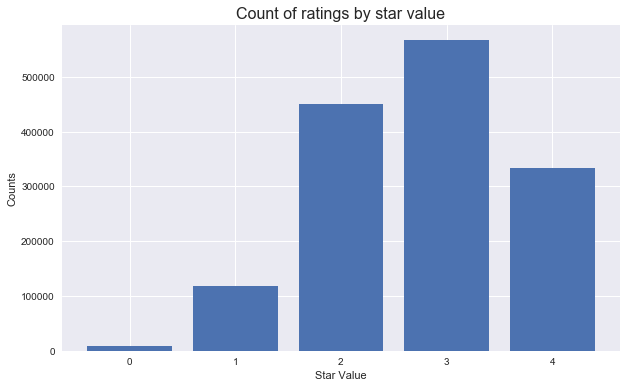

In [5]:
ah.plot_star_counts(df)

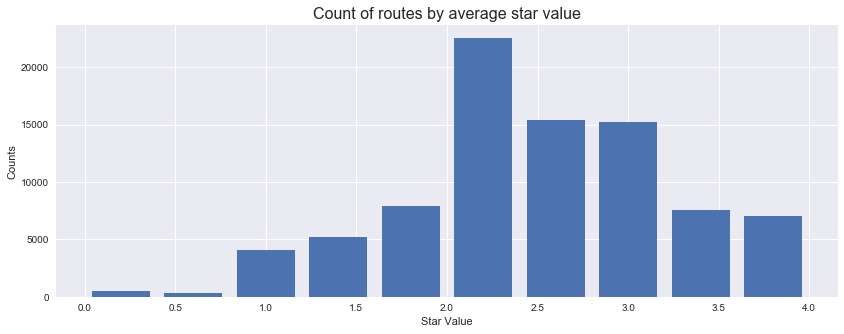

In [6]:
ah.hist_star_counts_byroute(df)

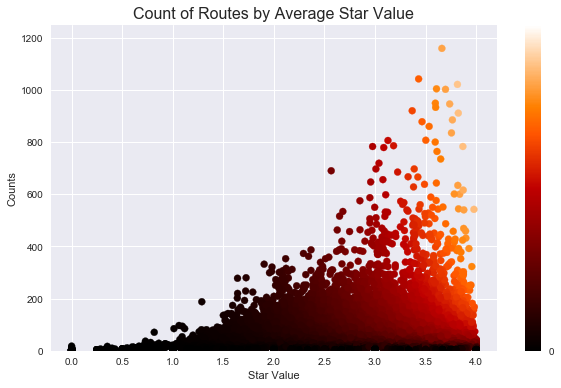

In [120]:
ah.scatter_stars_counts(df,'gist_heat')

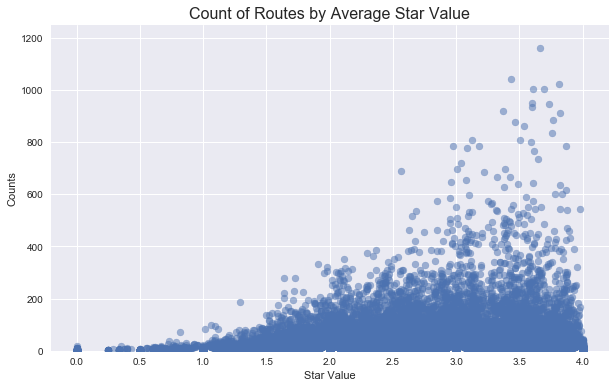

In [123]:
ah.scatter_stars_counts4(df,'Blues')

### Matrix Stats
Take a look at the density figures below and note that the matrix becomes *much more sparse* `in df_sample`, whereas `df_better_sample` is more comparable. Therefore we will use `df_better_sample` to do our model tuning in the event we need a smaller sample to reduce computation time.

In [8]:
ah.pr_mat_stats(df,'Original Matrix Stats')

Original Matrix Stats
---------------------
matrix size: 3352747324
matrix shape: users 85871, routes 39044
matrix density: 0.00044089156060720785


In [9]:
ah.pr_mat_stats(df_sample,'Sample Matrix Stats')

Sample Matrix Stats
---------------------
matrix size: 678702780
matrix shape: users 36810, routes 18438
matrix density: 0.00014733990039056567


In [10]:
ah.pr_mat_stats(df_better_sample, 'Better Sample Matrix Stats')

Better Sample Matrix Stats
---------------------
matrix size: 245861728
matrix shape: users 25648, routes 9586
matrix density: 0.0006962246682004936


### Distributions
- Users:
    - About half have rated 5 or fewer routes.
    - Users who rate more than 10 are likely to rate many more
- Routes:
    - About half of our routes have been rated by 5 our fewer. 
    - However, unlike routes, we continue to lose more routes as we raise our threshold

In [11]:
#try to normalize these hists

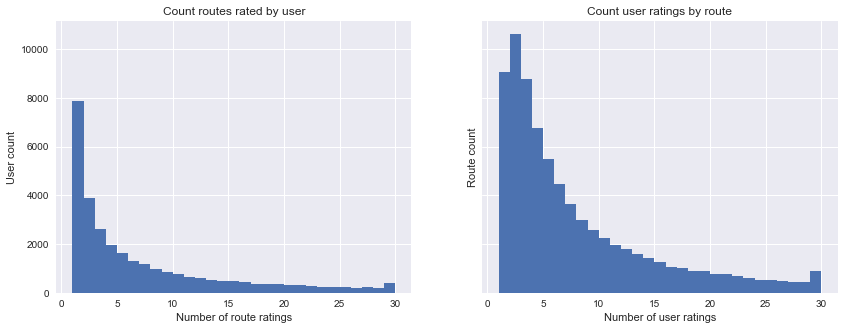

In [12]:
ah.plt_count_hists(df)

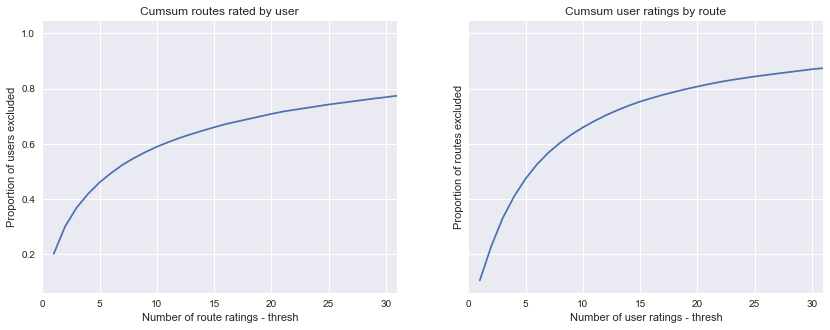

In [13]:
ah.plt_cumsum(df)

### Cold-start threshold and Matrix Density
Raising the cold-start threshold for both users and routes significantly increases the density of our matrix.
 - Intuatively, a denser matrix should be easier to predict (fewer black spots to fill) and improve the RMSE of our model.
 - It's worth noting that if we cut our threshold for both routes and users, with some users and routes who are pushed back under our cold-start threshold.

In [14]:
ah.pr_mat_stats(ah.rus_chop(df,10,10))

Matrix Stats
---------------------
matrix size: 527329536
matrix shape: users 31488, routes 16747
matrix density: 0.0022921947614935037


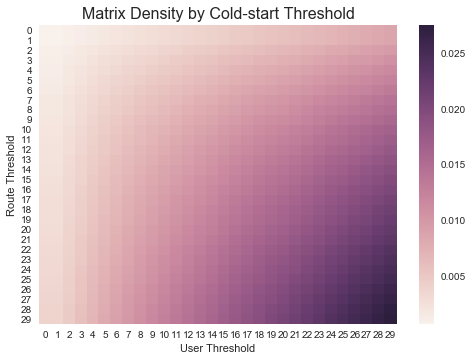

In [15]:
rus_density_thresh = ah.thresh_density_arr(df_better_sample,30,30)
ah.thresh_heatmap(rus_density_thresh,"Matrix Density by Cold-start Threshold")

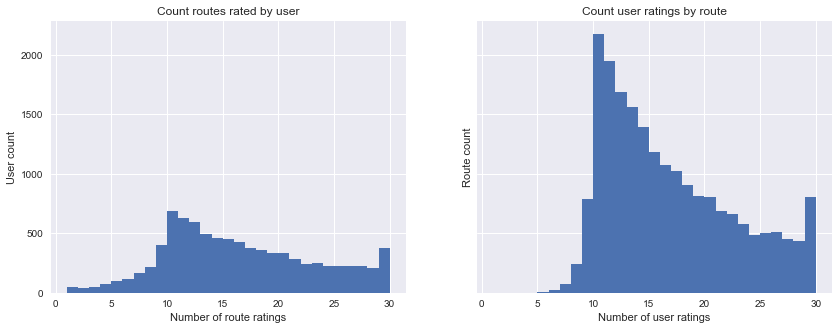

In [16]:
ah.plt_count_hists(ah.rus_chop(df,10,10))

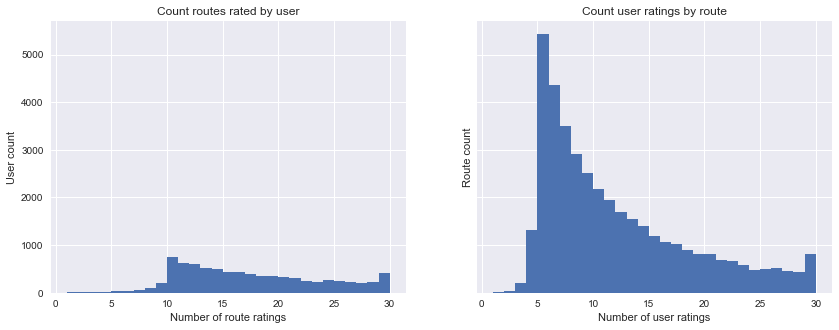

In [17]:
ah.plt_count_hists(ah.rus_chop(df,10,5))

### RMSE by cold-start threshold

In [19]:
arr_rmse, arr_mae, arr_fcp = ah.thresh_metrics_arrs(df_better_sample,30,30)

RMSE: 0.7188
MAE:  0.5735
FCP:  0.5514
RMSE: 0.7190
MAE:  0.5702
FCP:  0.5647
RMSE: 0.7076
MAE:  0.5640
FCP:  0.5634
RMSE: 0.6961
MAE:  0.5541
FCP:  0.5587
RMSE: 0.6893
MAE:  0.5505
FCP:  0.5589
RMSE: 0.6710
MAE:  0.5345
FCP:  0.5618
RMSE: 0.6712
MAE:  0.5335
FCP:  0.5711
RMSE: 0.6689
MAE:  0.5307
FCP:  0.5770
RMSE: 0.6616
MAE:  0.5261
FCP:  0.5729
RMSE: 0.6576
MAE:  0.5234
FCP:  0.5853
RMSE: 0.6590
MAE:  0.5229
FCP:  0.5886
RMSE: 0.6425
MAE:  0.5095
FCP:  0.5953
RMSE: 0.6536
MAE:  0.5168
FCP:  0.5854
RMSE: 0.6479
MAE:  0.5125
FCP:  0.5963
RMSE: 0.6469
MAE:  0.5131
FCP:  0.5864
RMSE: 0.6488
MAE:  0.5115
FCP:  0.5896
RMSE: 0.6428
MAE:  0.5082
FCP:  0.6146
RMSE: 0.6455
MAE:  0.5099
FCP:  0.5961
RMSE: 0.6394
MAE:  0.5029
FCP:  0.5991
RMSE: 0.6343
MAE:  0.5015
FCP:  0.6046
RMSE: 0.6321
MAE:  0.4986
FCP:  0.6148
RMSE: 0.6400
MAE:  0.5050
FCP:  0.5988
RMSE: 0.6306
MAE:  0.4978
FCP:  0.6141
RMSE: 0.6403
MAE:  0.5036
FCP:  0.6081
RMSE: 0.6268
MAE:  0.4982
FCP:  0.6047
RMSE: 0.6279
MAE:  0.4965

RMSE: 0.7178
MAE:  0.5745
FCP:  0.5584
RMSE: 0.7051
MAE:  0.5626
FCP:  0.5591
RMSE: 0.7001
MAE:  0.5582
FCP:  0.5611
RMSE: 0.6827
MAE:  0.5431
FCP:  0.5679
RMSE: 0.6786
MAE:  0.5404
FCP:  0.5808
RMSE: 0.6761
MAE:  0.5376
FCP:  0.5697
RMSE: 0.6689
MAE:  0.5327
FCP:  0.5841
RMSE: 0.6575
MAE:  0.5220
FCP:  0.5783
RMSE: 0.6564
MAE:  0.5224
FCP:  0.5824
RMSE: 0.6560
MAE:  0.5236
FCP:  0.5864
RMSE: 0.6512
MAE:  0.5175
FCP:  0.5971
RMSE: 0.6489
MAE:  0.5155
FCP:  0.5914
RMSE: 0.6474
MAE:  0.5146
FCP:  0.5971
RMSE: 0.6429
MAE:  0.5093
FCP:  0.5980
RMSE: 0.6414
MAE:  0.5096
FCP:  0.5876
RMSE: 0.6376
MAE:  0.5037
FCP:  0.6044
RMSE: 0.6316
MAE:  0.5028
FCP:  0.6046
RMSE: 0.6415
MAE:  0.5073
FCP:  0.5907
RMSE: 0.6261
MAE:  0.4960
FCP:  0.6148
RMSE: 0.6444
MAE:  0.5101
FCP:  0.6001
RMSE: 0.6257
MAE:  0.4957
FCP:  0.6159
RMSE: 0.6314
MAE:  0.4985
FCP:  0.6252
RMSE: 0.6389
MAE:  0.5038
FCP:  0.5953
RMSE: 0.6301
MAE:  0.4975
FCP:  0.6149
RMSE: 0.6223
MAE:  0.4932
FCP:  0.6210
RMSE: 0.6231
MAE:  0.4926

FCP:  0.5560
RMSE: 0.7104
MAE:  0.5676
FCP:  0.5486
RMSE: 0.7023
MAE:  0.5613
FCP:  0.5610
RMSE: 0.6887
MAE:  0.5490
FCP:  0.5565
RMSE: 0.6774
MAE:  0.5404
FCP:  0.5739
RMSE: 0.6730
MAE:  0.5357
FCP:  0.5765
RMSE: 0.6659
MAE:  0.5319
FCP:  0.5869
RMSE: 0.6675
MAE:  0.5328
FCP:  0.5794
RMSE: 0.6629
MAE:  0.5276
FCP:  0.5751
RMSE: 0.6500
MAE:  0.5184
FCP:  0.5916
RMSE: 0.6537
MAE:  0.5218
FCP:  0.5821
RMSE: 0.6494
MAE:  0.5151
FCP:  0.5844
RMSE: 0.6424
MAE:  0.5105
FCP:  0.5832
RMSE: 0.6463
MAE:  0.5128
FCP:  0.5942
RMSE: 0.6393
MAE:  0.5076
FCP:  0.5974
RMSE: 0.6394
MAE:  0.5071
FCP:  0.6054
RMSE: 0.6367
MAE:  0.5059
FCP:  0.5865
RMSE: 0.6369
MAE:  0.5030
FCP:  0.6076
RMSE: 0.6332
MAE:  0.5008
FCP:  0.6044
RMSE: 0.6208
MAE:  0.4943
FCP:  0.6027
RMSE: 0.6232
MAE:  0.4978
FCP:  0.6268
RMSE: 0.6301
MAE:  0.4996
FCP:  0.6119
RMSE: 0.6265
MAE:  0.4949
FCP:  0.6088
RMSE: 0.6303
MAE:  0.5007
FCP:  0.6134
RMSE: 0.6197
MAE:  0.4908
FCP:  0.6227
RMSE: 0.6241
MAE:  0.4936
FCP:  0.6210
RMSE: 0.6238

RMSE: 0.7100
MAE:  0.5671
FCP:  0.5624
RMSE: 0.6925
MAE:  0.5542
FCP:  0.5624
RMSE: 0.6886
MAE:  0.5500
FCP:  0.5643
RMSE: 0.6831
MAE:  0.5449
FCP:  0.5743
RMSE: 0.6826
MAE:  0.5417
FCP:  0.5767
RMSE: 0.6723
MAE:  0.5347
FCP:  0.5807
RMSE: 0.6591
MAE:  0.5240
FCP:  0.5793
RMSE: 0.6633
MAE:  0.5291
FCP:  0.5898
RMSE: 0.6594
MAE:  0.5267
FCP:  0.5719
RMSE: 0.6539
MAE:  0.5195
FCP:  0.5882
RMSE: 0.6539
MAE:  0.5203
FCP:  0.5857
RMSE: 0.6520
MAE:  0.5209
FCP:  0.5934
RMSE: 0.6458
MAE:  0.5128
FCP:  0.6000
RMSE: 0.6399
MAE:  0.5092
FCP:  0.5928
RMSE: 0.6417
MAE:  0.5094
FCP:  0.5905
RMSE: 0.6390
MAE:  0.5071
FCP:  0.6047
RMSE: 0.6296
MAE:  0.4977
FCP:  0.5969
RMSE: 0.6269
MAE:  0.4969
FCP:  0.5996
RMSE: 0.6305
MAE:  0.5011
FCP:  0.6121
RMSE: 0.6263
MAE:  0.4947
FCP:  0.6089
RMSE: 0.6237
MAE:  0.4948
FCP:  0.6208
RMSE: 0.6294
MAE:  0.4980
FCP:  0.5995
RMSE: 0.6161
MAE:  0.4888
FCP:  0.6122
RMSE: 0.6262
MAE:  0.4971
FCP:  0.6118
RMSE: 0.6251
MAE:  0.4967
FCP:  0.6107
RMSE: 0.6171
MAE:  0.4882

FCP:  0.5648
RMSE: 0.7050
MAE:  0.5653
FCP:  0.5555
RMSE: 0.6968
MAE:  0.5577
FCP:  0.5657
RMSE: 0.6872
MAE:  0.5473
FCP:  0.5728
RMSE: 0.6789
MAE:  0.5433
FCP:  0.5681
RMSE: 0.6630
MAE:  0.5312
FCP:  0.5763
RMSE: 0.6618
MAE:  0.5293
FCP:  0.5964
RMSE: 0.6639
MAE:  0.5314
FCP:  0.5746
RMSE: 0.6595
MAE:  0.5245
FCP:  0.5821
RMSE: 0.6543
MAE:  0.5210
FCP:  0.5831
RMSE: 0.6552
MAE:  0.5224
FCP:  0.5825
RMSE: 0.6462
MAE:  0.5154
FCP:  0.5809
RMSE: 0.6424
MAE:  0.5107
FCP:  0.6034
RMSE: 0.6467
MAE:  0.5146
FCP:  0.5888
RMSE: 0.6362
MAE:  0.5071
FCP:  0.5917
RMSE: 0.6467
MAE:  0.5139
FCP:  0.6013
RMSE: 0.6360
MAE:  0.5077
FCP:  0.5940
RMSE: 0.6340
MAE:  0.5027
FCP:  0.5992
RMSE: 0.6367
MAE:  0.5057
FCP:  0.6082
RMSE: 0.6277
MAE:  0.4992
FCP:  0.6040
RMSE: 0.6220
MAE:  0.4955
FCP:  0.6068
RMSE: 0.6283
MAE:  0.4978
FCP:  0.6229
RMSE: 0.6322
MAE:  0.5016
FCP:  0.6222
RMSE: 0.6162
MAE:  0.4887
FCP:  0.6036
RMSE: 0.6050
MAE:  0.4819
FCP:  0.6075
RMSE: 0.6199
MAE:  0.4912
FCP:  0.5998
RMSE: 0.6240

In the plots below, I fit the 'Funk style SVD' algorithm from the `surprise` package to a training set from our `df_better_sample`. We then plot the RMSE while varying the cold-start threshold.
 - Raising the user threshold up to about 10 clearly improves the predictive power of our model. After that we hit diminishing returns and begin to see some noise.
 - The effect of raising the route threshold is less clear. There seems to be some improvement 
 - However, as it turns out, by removing routes we end up removing some of the 'information' that we are using to predict users ratings. As a result, once we raise the threshold beyond 5 we see a lot of noise and even a trend upward in RMSE.
 
With the Surprise SVD algorithm, cold-start users will receive predicted scores based on the 'average user', which as it turns out is still very useful in our recommender engine. Therefore I'm okay with raising the user rating threshold to 10 and thereby giving personalized recommendations to **30%** of our userbase. Once we meet this threshold we have enough info to give a user **personalized** recommendations.

I'm going to cut routes off for the model at a cold-start threshold of 3, because less trafficked routes tend to be obscure and there is some noise / bad data and routes that don't actually exist in this region. Routes in the 3-10 region it seems may provide the model with some useful information, however, they still wouldn't be considered **classics** and I want my recommender to return well-known and quality routes so I am going to include these routes in the model, but remove them from the recommender.

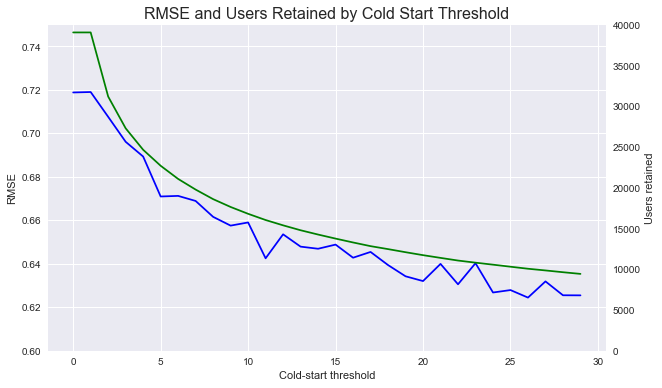

In [20]:
ah.plot_RMSE_userthresh(df, arr_rmse,'RMSE and Users Retained by Cold Start Threshold')

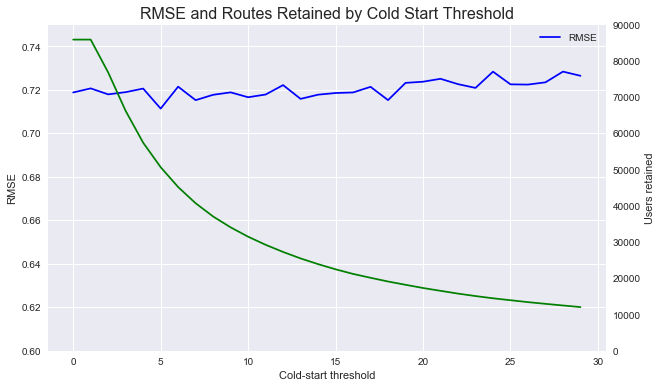

In [21]:
ah.plot_RMSE_routethresh(df, arr_rmse,'RMSE and Routes Retained by Cold Start Threshold')

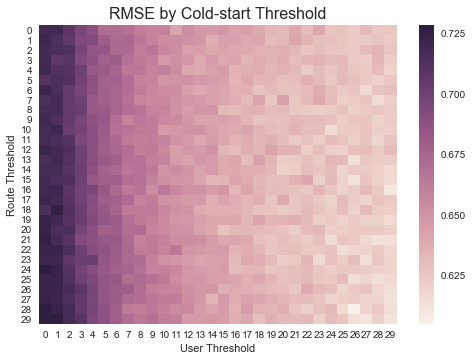

In [22]:
ah.thresh_heatmap(arr_rmse,"RMSE by Cold-start Threshold")

### Fit Models

- SVD ++ takes into account 'implicit' ratings - ie if a user is more likely to rate something if they like it. 

In [103]:
df_chopped_u10_r3 = ah.rus_chop(df,10,3)

In [104]:
reader = Reader(line_format='user item rating', sep=',', skip_lines=1)
data = Dataset.load_from_df(df_chopped_u10_r3, reader=reader)
trainset, testset = train_test_split(data, test_size=.2)
algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.6498


0.6498113746748263

In [106]:
# # Do not run locally - HEAVY
# reader = Reader(line_format='user item rating', sep=',', skip_lines=1)
# data = Dataset.load_from_df(df_chopped_u10_r3, reader=reader)
# trainset, testset = train_test_split(data, test_size=.2)
# algo_pp = SVDpp(n_epochs=100, reg_all=.1, lr_all=.006)
# algo_pp.fit(trainset)
# predictions = algo_pp.test(testset)
# accuracy.rmse(predictions)

In [26]:
# # Do not run locally - HEAVY
# param_grid = {  'n_epochs'  : [100],
#                 'n_factors' : [15, 20, 25, 30, 40]
#                 'lr_all'    : [0.002, 0.004, 0.006, 0.008],
#                 'reg_all'   : [0.06, 0.08, 0.1, 0.2]}

# df_chopped_u10_r3 = ah.rus_chop(df,10,3)
# reader = Reader(line_format='user item rating', sep=',', skip_lines=1)
# data = Dataset.load_from_df(df_chopped_u10_r3, reader=reader)
# ah.suprise_gridsearch(data, SVDpp, param_grid)

##### How'd we do?

The violin plot below shows that the predicted ratings trend nicely with the true ratings and that there is a good correlation in the 3 to 4 region where it counts for a top 10 recommender.

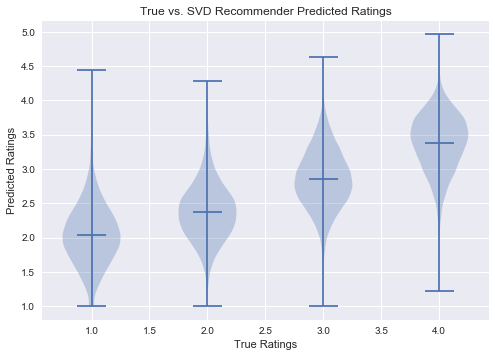

In [132]:
ah.violins(algo, testset)

### Appendix

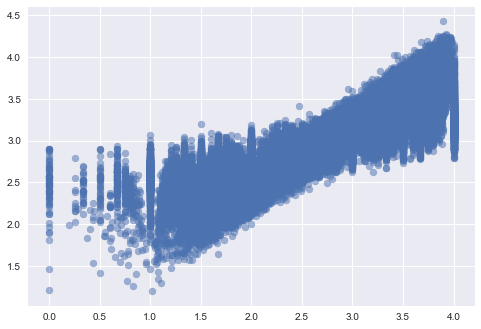

In [119]:
plt.scatter(df_merge['mean'],df_merge['est'],alpha = .5)

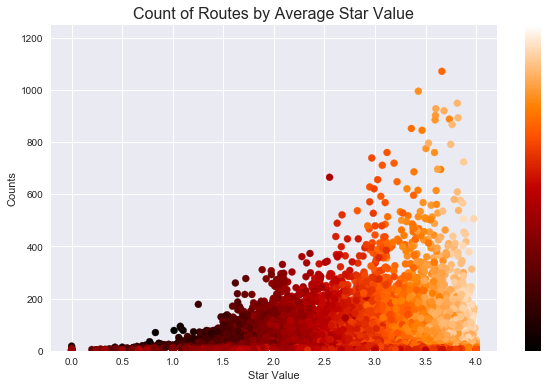

In [118]:
ah.scatter_stars_counts3(df_merge,'gist_heat')

In [ ]:
ah.plot_errorbars(df)

In [ ]:
ah.plt_count_hists(df_sample)

In [ ]:
ah.plt_count_hists(df_better_sample)

In [ ]:
ah.thresh_heatmap(arr_mae,"MAE by Cold-start Threshold")

In [ ]:
ah.thresh_heatmap(arr_fcp,"FCP by Cold-start Threshold")